In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
%matplotlib inline

## One-vs-All Classifier

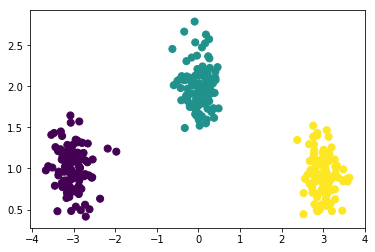

In [34]:
# Create training data
np.random.seed(2)
X, y = make_blobs(n_samples=300,cluster_std=.25,\
                  centers=np.array([(-3,1),(0,2),(3,1)]))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)

In [35]:
num_samples, num_inFeatures = (1,X.shape[0]) if len(X.shape) == 1 else (X.shape[0],X.shape[1])
num_classes = 3

In [38]:
for j in range(num_classes):
    empty_v = np.zeros(num_classes * num_inFeatures)
    empty_v[(j*num_inFeatures):(j+1)*num_inFeatures] = X[0]
    print(empty_v)

[-2.90738887  1.33990847  0.          0.          0.          0.        ]
[ 0.          0.         -2.90738887  1.33990847  0.          0.        ]
[ 0.          0.          0.          0.         -2.90738887  1.33990847]


In [40]:
np.tile(A = X,reps=num_classes)  

array([[-2.90738887,  1.33990847, -2.90738887,  1.33990847, -2.90738887,
         1.33990847],
       [ 2.83555791,  0.6871379 ,  2.83555791,  0.6871379 ,  2.83555791,
         0.6871379 ],
       [ 2.85131938,  0.92129704,  2.85131938,  0.92129704,  2.85131938,
         0.92129704],
       ..., 
       [-2.74990853,  0.90472687, -2.74990853,  0.90472687, -2.74990853,
         0.90472687],
       [-0.28917479,  2.30850867, -0.28917479,  2.30850867, -0.28917479,
         2.30850867],
       [-3.11355696,  1.12859268, -3.11355696,  1.12859268, -3.11355696,
         1.12859268]])

In [41]:
empty_v = np.zeros(num_classes * num_inFeatures)

In [42]:
def featureMap(X,y,num_classes) :
    #class sensitive feature mapping
    '''
    Computes the class-sensitive features.
    @param X: array-like, shape = [n_samples,n_inFeatures] 
                or [n_inFeatures,], input features for input data
    @param y: a target class (in range 0,..,num_classes-1)
    @return array-like, shape = [n_samples,n_outFeatures], 
                        the class sensitive features for class y
    '''
    #The following line handles X being a 1d-array or a 2d-array
    num_samples, num_inFeatures = (1,X.shape[0]) if len(X.shape) == 1 else (X.shape[0],X.shape[1])
    X_new = np.tile(A = X,reps=num_classes)      
    return X_new

X_new = featureMap(X,y,num_classes = 3)
X_new

array([[-2.90738887,  1.33990847, -2.90738887,  1.33990847, -2.90738887,
         1.33990847],
       [ 2.83555791,  0.6871379 ,  2.83555791,  0.6871379 ,  2.83555791,
         0.6871379 ],
       [ 2.85131938,  0.92129704,  2.85131938,  0.92129704,  2.85131938,
         0.92129704],
       ..., 
       [-2.74990853,  0.90472687, -2.74990853,  0.90472687, -2.74990853,
         0.90472687],
       [-0.28917479,  2.30850867, -0.28917479,  2.30850867, -0.28917479,
         2.30850867],
       [-3.11355696,  1.12859268, -3.11355696,  1.12859268, -3.11355696,
         1.12859268]])

In [43]:
def sgd(X, y, num_outFeatures, subgd, eta = 0.05, T = 10000):
    w_vec = np.zeros(num_outFeatures)
    w_updates = [w_vec]
    num_samples = X.shape[0]
    m_svm = MulticlassSVM(6)
    for num_iter in range(T):
        for i in range(num_samples):
            grad = m_svm.subgradient(X[i],y[i],w_vec)
            w_vec = w_vec - eta*grad
        w = w_vec
        w_updates.append(w)
    w_fin = np.zeros((num_outFeatures))
    w_updates = np.vstack((w_updates))
    for a in range(len(w_fin)):
        w_fin[a] = np.mean(w_updates[:,a])
    return np.array(w_fin)

In [44]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone

class OneVsAllClassifier(BaseEstimator, ClassifierMixin):  
    """
    One-vs-all classifier
    We assume that the classes will be the integers 0,..,(n_classes-1).
    We assume that the estimator provided to the class, after fitting, has a "decision_function" that 
    returns the score for the positive class.
    """
    def __init__(self, estimator, n_classes):      
        """
        Constructed with the number of classes and an estimator (e.g. an
        SVM estimator from sklearn)
        @param estimator : binary base classifier used
        @param n_classes : number of classes
        """
        self.n_classes = n_classes 
        self.estimators = [clone(estimator) for _ in range(n_classes)]
        self.fitted = False

    def fit(self, X, y=None):
        """
        This should fit one classifier for each class.
        self.estimators[i] should be fit on class i vs rest
        @param X: array-like, shape = [n_samples,n_features], input data
        @param y: array-like, shape = [n_samples,] class labels
        @return returns self
        """
        n_classes = self.n_classes
        for k in range(n_classes):
            X_k = X
            y_k = np.array([1 if i == k else -1 for i in y])
            self.estimators[k].fit(X_k,y_k)
        self.fitted = True
        return self

    def decision_function(self, X):
        """
        Returns the score of each input for each class. Assumes
        that the given estimator also implements the decision_function method (which sklearn SVMs do), 
        and that fit has been called.
        @param X : array-like, shape = [n_samples, n_features] input data
        @return array-like, shape = [n_samples, n_classes]
        """
        if not self.fitted:
            raise RuntimeError("You must train classifer before predicting data.")
        if not hasattr(self.estimators[0], "decision_function"):
            raise AttributeError("Base estimator doesn't have a decision_function attribute.")
        n_classes = self.n_classes
        sample_scores = np.zeros((X.shape[0], n_classes))
        estimators = self.estimators
        for k in range(n_classes):
            sample_scores[:,k] = estimators[k].decision_function(X)
        return sample_scores
    
    def predict(self, X):
        """
        Predict the class with the highest score.
        @param X: array-like, shape = [n_samples,n_features] input data
        @returns array-like, shape = [n_samples,] the predicted classes for each input
        """
        # Get the scores
        sample_scores = self.decision_function(X) 
        # Select the class to show
        preds = np.zeros(sample_scores.shape[0]) 
        for i in range(sample_scores.shape[0]):
            if type(np.amax(sample_scores[i])) == int:
                for k in range(sample_scores.shape[1]):
                    if np.amax(sample_scores[i]) == sample_scores[i][k]:
                        preds[i] = k
            else: 
                ks=[]
                for k in range(sample_scores.shape[1]):
                    if np.amax(sample_scores[i]) == sample_scores[i][k]:
                        ks.append(k)
                preds[i] = np.random.choice(ks)
        return preds

Coeffs 0
[[-1.05852747 -0.90296521]]
Coeffs 1
[[ 0.22117096 -0.38900908]]
Coeffs 2
[[ 0.89162796 -0.82467394]]


array([[100,   0,   0],
       [  0, 100,   0],
       [  0,   0, 100]])

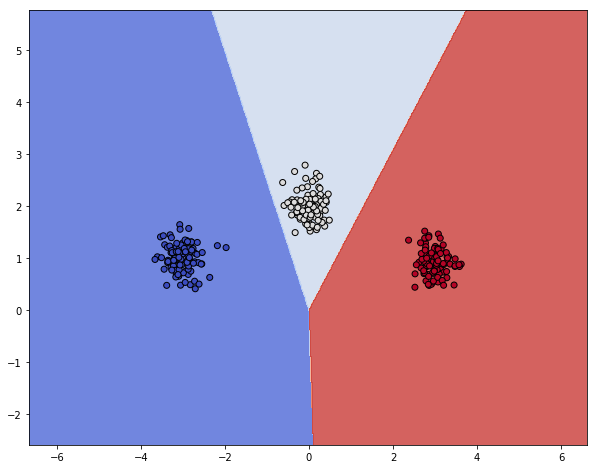

In [45]:
#Here we test the OneVsAllClassifier
from sklearn import svm
svm_estimator = svm.LinearSVC(loss='hinge', fit_intercept=False, C=200)
clf_onevsall = OneVsAllClassifier(svm_estimator, n_classes=3)
clf_onevsall.fit(X,y)

for i in range(3) :
    print("Coeffs %d"%i)
    print(clf_onevsall.estimators[i].coef_) #Will fail if you haven't implemented fit yet

# create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = min(X[:,0])-3,max(X[:,0])+3
y_min, y_max = min(X[:,1])-3,max(X[:,1])+3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
mesh_input = np.c_[xx.ravel(), yy.ravel()]
plt.figure(figsize=(10,8))
Z = clf_onevsall.predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8,edgecolor="k")
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm,edgecolor="k")

from sklearn import metrics
metrics.confusion_matrix(y, clf_onevsall.predict(X))